# Predicting Customer Churn (Logistic Regression)

Step-by-step notebook for preprocessing, training, and evaluating a logistic regression model on the Telco Customer Churn dataset.

In [1]:

# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib


In [2]:
import os
os.chdir('..') 

## 1) Load data
Place the CSV in `data/Telco-Customer-Churn.csv`.

In [3]:
df = pd.read_csv('data/Telco-Customer-Churn.csv')
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2) Preprocessing and cleaning

In [4]:

# Drop customerID and clean TotalCharges
df_clean = df.copy()
if 'customerID' in df_clean.columns:
    df_clean = df_clean.drop(columns=['customerID'])
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
df_clean['TotalCharges'] = df_clean['TotalCharges'].fillna(df_clean['MonthlyCharges'] * df_clean['tenure'])
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


## 3) Encoding categorical features

In [5]:

y = df_clean['Churn'].map({'Yes':1,'No':0})
X = df_clean.drop(columns=['Churn'])
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X_encoded.shape


(7043, 30)

## 4) Train-test split

In [6]:

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape


((5634, 30), (1409, 30))

## 5) Train Logistic Regression

In [7]:

scaler = StandardScaler()
clf = LogisticRegression(max_iter=1000, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}")


Test accuracy: 0.8070


## 6) Evaluation: Confusion Matrix and Interpretation

Confusion matrix:
 [[925 110]
 [162 212]]

Classification report:
               precision    recall  f1-score   support

           0     0.8510    0.8937    0.8718      1035
           1     0.6584    0.5668    0.6092       374

    accuracy                         0.8070      1409
   macro avg     0.7547    0.7303    0.7405      1409
weighted avg     0.7998    0.8070    0.8021      1409



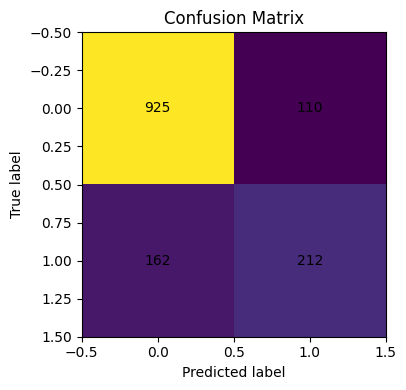

In [8]:

cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)
print('\nClassification report:\n', classification_report(y_test, y_pred, digits=4))
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i,j]), ha='center', va='center')
plt.tight_layout()
plt.show()


## 7) Save the trained model (pipeline)

In [9]:

import os
os.makedirs('models', exist_ok=True)
# Save scaler + model together as a pipeline-like dict
joblib.dump({'scaler': scaler, 'model': clf, 'feature_columns': X_encoded.columns.tolist()}, 'models/logistic_model.joblib')
print('Saved model to models/logistic_model.joblib')


Saved model to models/logistic_model.joblib



### Interpreting the confusion matrix:
The confusion matrix is a 2x2 table for binary classification:
- **True Negative (TN)**: top-left — actual No, predicted No.
- **False Positive (FP)**: top-right — actual No, predicted Yes.
- **False Negative (FN)**: bottom-left — actual Yes, predicted No.
- **True Positive (TP)**: bottom-right — actual Yes, predicted Yes.

From these numbers you can compute precision, recall, and F1-score:
- **Precision**: TP / (TP + FP) — how many predicted churners actually churned.
- **Recall (Sensitivity)**: TP / (TP + FN) — how many actual churners were correctly identified.
- **If recall is low** the model misses many churners (you'll fail to target them).
- **If precision is low** many customers you'll target won't churn (wasted incentives).
Consider the business cost of false negatives vs false positives when choosing thresholds.
